# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post MST.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel
from pingouin import ttest, normality, wilcoxon

from mst_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
%matplotlib inline

### Functions

In [3]:
def perm_test(df, feature='', nreps=10000, seed=256, plot_hist=True, run_ttest=True):
    '''permutation test from https://www.uvm.edu/\~statdhtx/StatPages/\
    ResamplingWithR/RandomMatchedSample/RandomMatchedSampleR.html
    '''
    
    means_pre = df[df['pre_post']=='pre'][feature].values
    means_post = df[df['pre_post']=='post'][feature].values
    
    diff_obt = np.nanmedian(means_post) - np.nanmedian(means_pre)
    difference = means_post-means_pre
    
    np.random.seed(seed)
    resamp_mean_diff = np.zeros(nreps)

    for i in range(0, nreps):
        signs = np.random.choice([1, -1], len(difference), replace=True)
        resamp = difference * signs
        resamp_mean_diff[i] = np.nanmedian(resamp)

    diff_obt = abs(diff_obt)
    highprob = len(resamp_mean_diff[resamp_mean_diff >= diff_obt])/nreps
    lowprob = len(resamp_mean_diff[resamp_mean_diff <= -diff_obt])/nreps
    prob2tailed = lowprob + highprob

    print("The probability from the sampling statistics is = ",prob2tailed,'\n')

    if plot_hist:
        plt.hist(resamp_mean_diff, bins=30);
        plt.title(feature)
        plt.xlabel('Median Difference')
        plt.axvline(x=diff_obt, c='r')
        plt.axvline(x=-diff_obt, c='r')

    # compare to student's t-test
    if run_ttest:
        print(ttest(means_pre, means_post, paired=True))

In [4]:
FRONTAL_ONLY = False

In [5]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels from ppn's with bad fits
exp_df_included = exp_df[exp_df['exclude']==False]


In [6]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]
else:
    exp_df_included = exp_df

## Load SpecParam Fits

In [7]:
fits_pre = np.load('../saved_files_appeal/mst_files/mst_fits_pre.npy')
fits_post = np.load('../saved_files_appeal/mst_files/mst_fits_post.npy')
freq_axis = np.load('../saved_files_appeal/mst_files/mst_freq_axis.npy')

**Correct for excluded fits**

In [8]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [9]:
psd_pre = np.load('../saved_files_appeal/mst_files/pre_mst_psd.npy')
psd_post = np.load('../saved_files_appeal/mst_files/post_mst_psd.npy')

**Correct for excluded PSD's**

In [10]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [11]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,9,pre,FP1,NaN,NaN,0.0,-11.283243,6.160561,3.012282,0.722517,-11.315310,9.540913,2.163893,1.129194,-11.300131,-10.910216,1.385597,0.068730,0.981048,False
1,9,pre,FPZ,NaN,NaN,0.0,-11.311451,6.265365,3.086557,0.733975,-11.328971,9.583599,2.081748,1.151045,-11.294941,-10.944674,1.359475,0.069224,0.980534,False
2,9,pre,FP2,NaN,NaN,0.0,-11.285025,NaN,NaN,0.000000,-11.403185,8.828444,5.516757,0.979455,-11.320865,-10.902679,1.417495,0.073972,0.978797,False
3,9,pre,AF3,NaN,NaN,0.0,-11.235786,NaN,NaN,0.000000,-11.160861,10.032387,8.000000,0.986879,-11.267972,-10.919900,1.315336,0.129817,0.947035,False
4,9,pre,AF4,NaN,NaN,0.0,-11.277961,5.176093,1.263650,0.715413,-11.283006,8.727501,4.945225,0.997578,-11.301249,-10.889718,1.419578,0.071667,0.979583,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,191,post,PO6,NaN,NaN,0.0,-11.774113,6.139891,3.100660,0.467476,-11.828470,8.800853,1.814433,1.723120,-11.188669,-11.364319,1.234819,0.066362,0.987620,False
2756,191,post,PO8,NaN,NaN,0.0,-11.771589,NaN,NaN,0.000000,-11.868800,9.042060,3.424618,1.501029,-11.254407,-11.341603,1.255972,0.104854,0.968433,False
2757,191,post,O1,NaN,NaN,0.0,-11.757973,4.199002,1.516109,0.395459,-11.809631,8.773147,1.088419,1.721570,-11.278803,-11.430549,1.197102,0.060777,0.987291,False
2758,191,post,OZ,NaN,NaN,0.0,-11.736114,5.705399,1.000000,0.412440,-11.817168,8.694386,1.008885,1.629046,-11.328935,-11.264617,1.344792,0.057019,0.990354,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

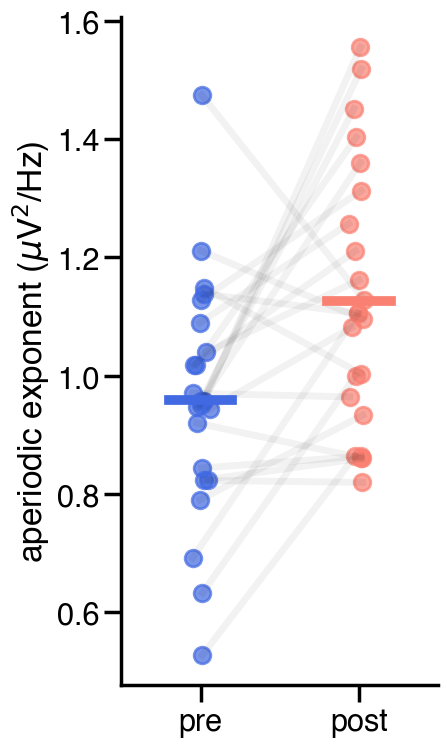

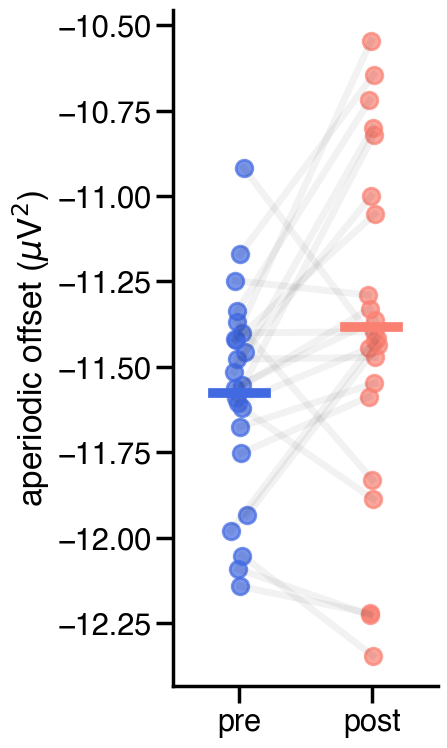

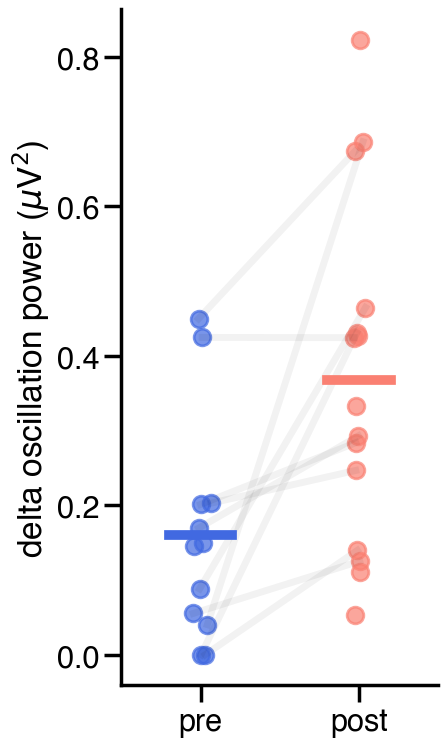

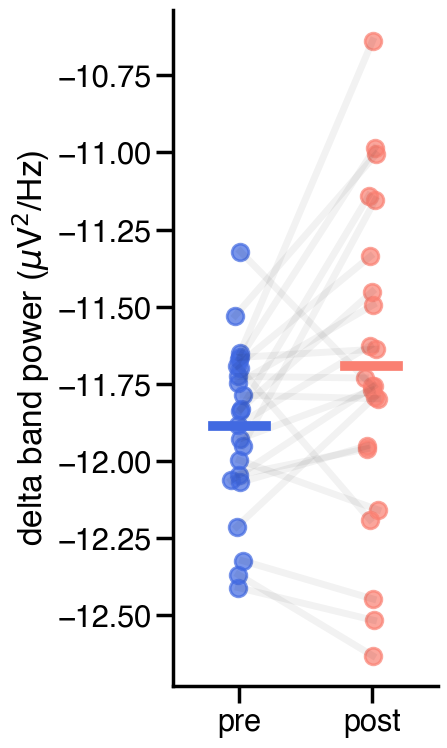

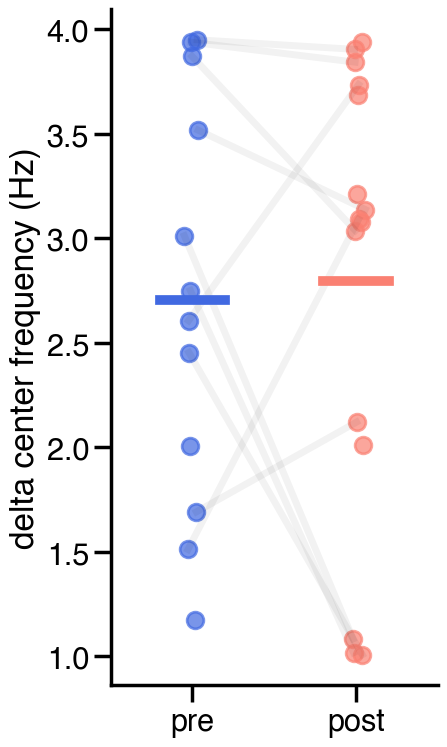

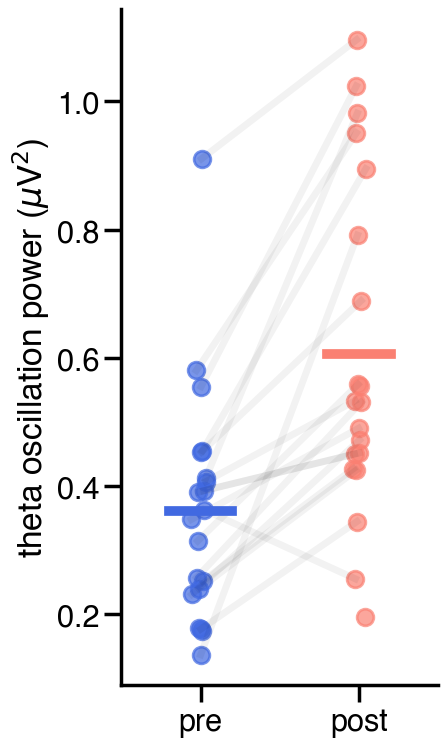

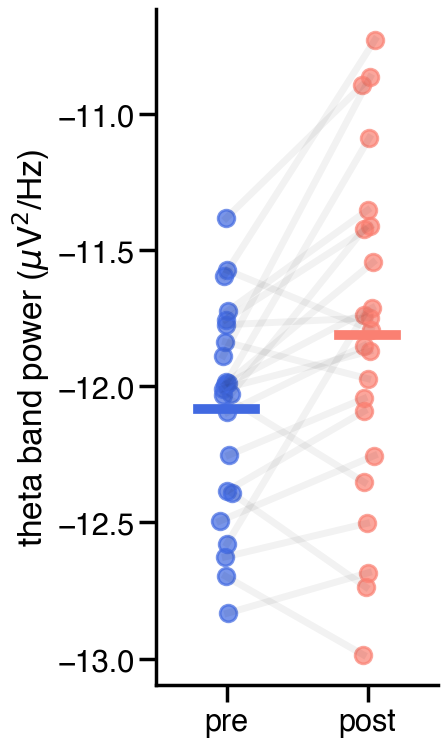

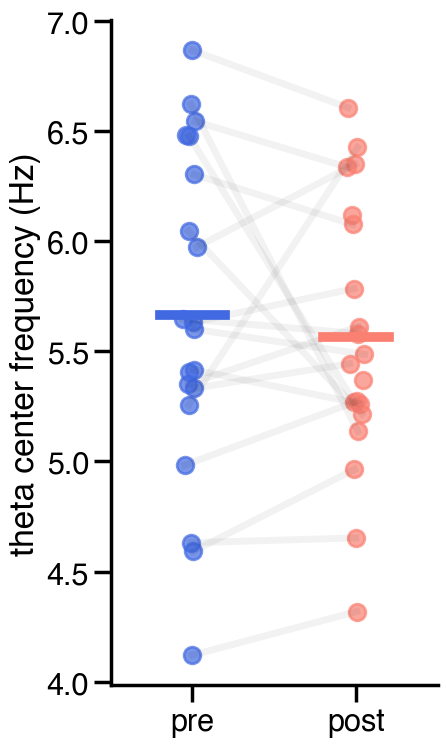

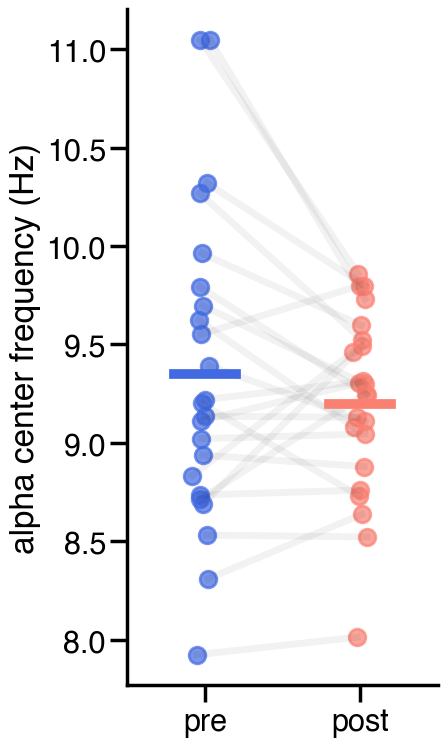

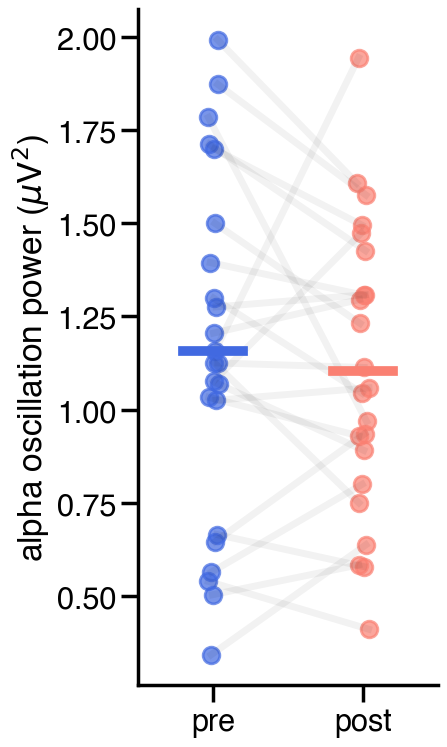

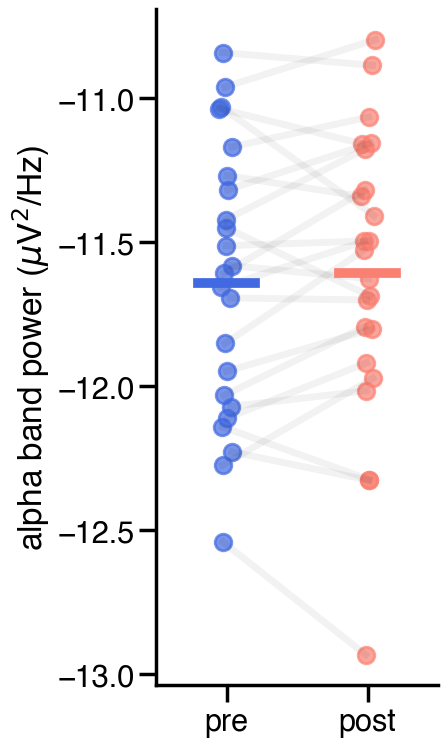

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)', 'alpha band power ($\mu$V$^2$/Hz)' ]

for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

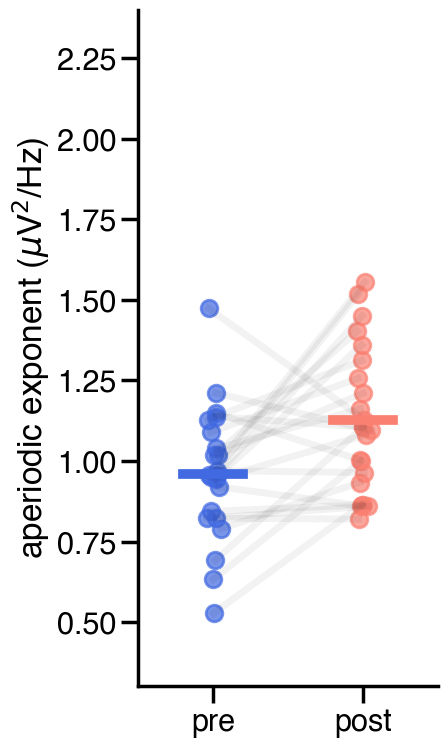

In [15]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 2.4)
sns.despine()
plt.tight_layout()
plt.show()

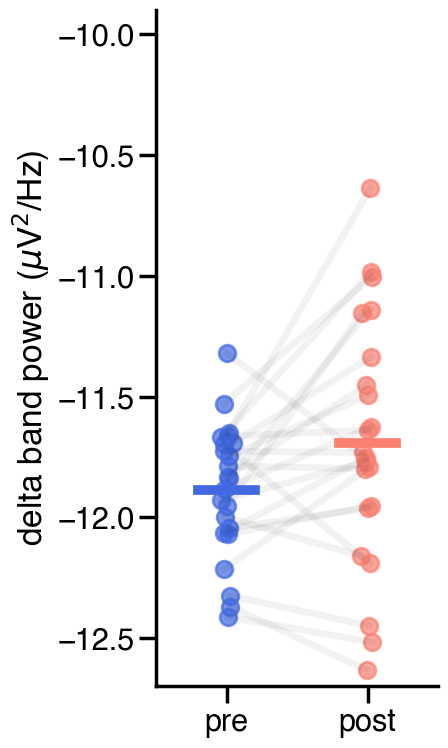

In [16]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -9.9)
sns.despine()
plt.tight_layout()
plt.show()

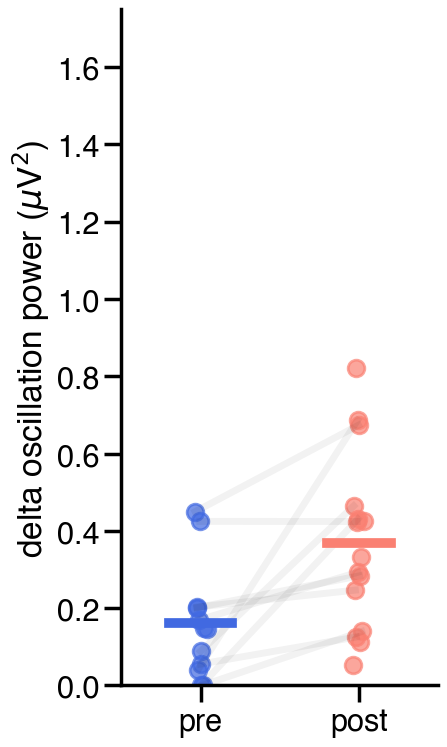

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

## Plot Spectra

In [18]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

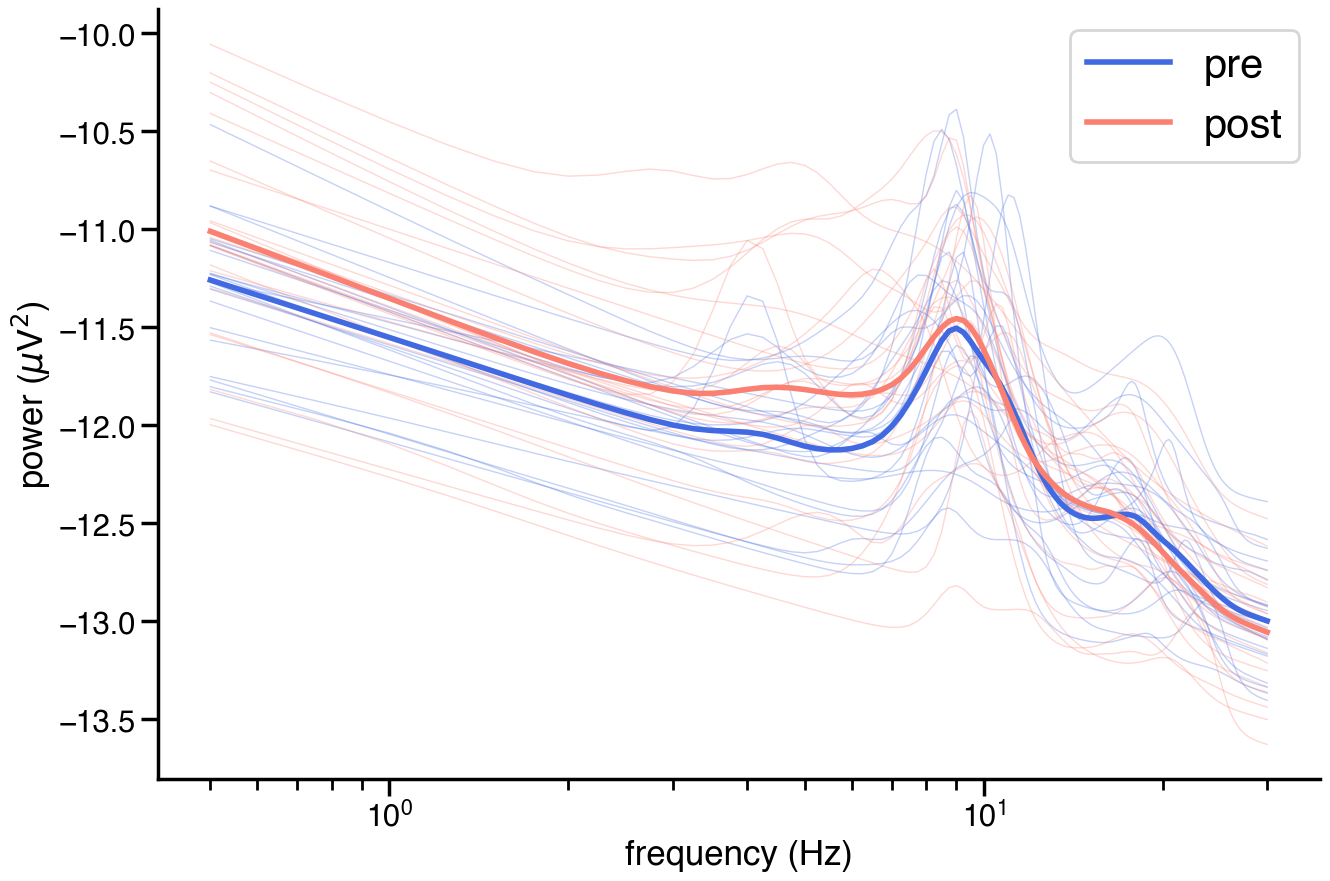

<Figure size 640x480 with 0 Axes>

In [19]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot SpecParam Fits

In [20]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

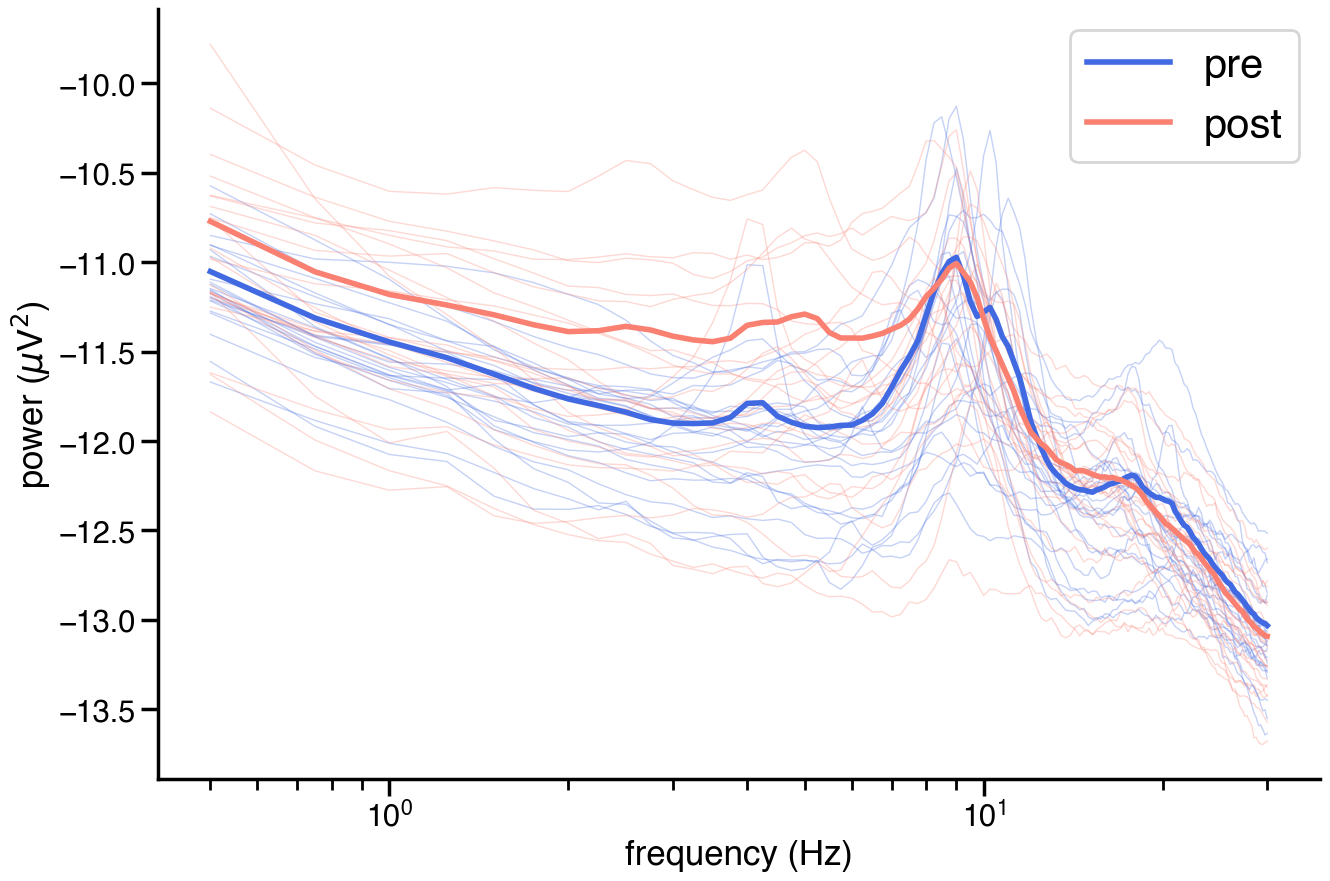

In [21]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_pre_mean[patient,2:121]), color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_post_mean[patient,2:121]), color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], np.log10(psd_pre_grand_mean[2:121]), color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], np.log10(psd_post_grand_mean[2:121]), color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [22]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.970972  0.712266    True
          W      pval  normal
0  0.939928  0.179078    True


In [23]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.96 std: 0.2
post: 1.13 std: 0.22


**Distribution of means pre vs. post**

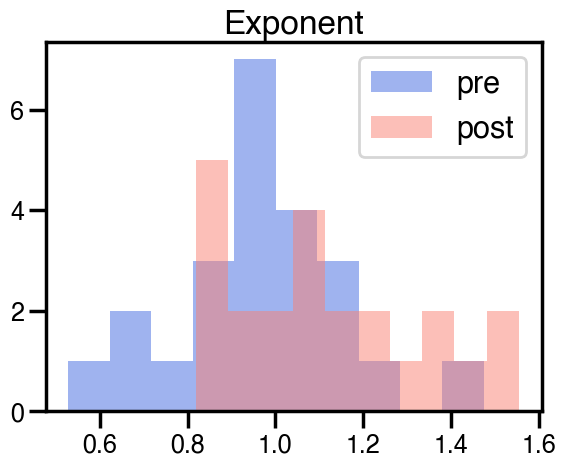

In [24]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [25]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   47.0   two-sided  0.004339 -0.65942  0.302457


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0005 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.292454   22   two-sided  0.003321  [-0.27, -0.06]  0.788725  12.512   

           power  
T-test  0.950826  


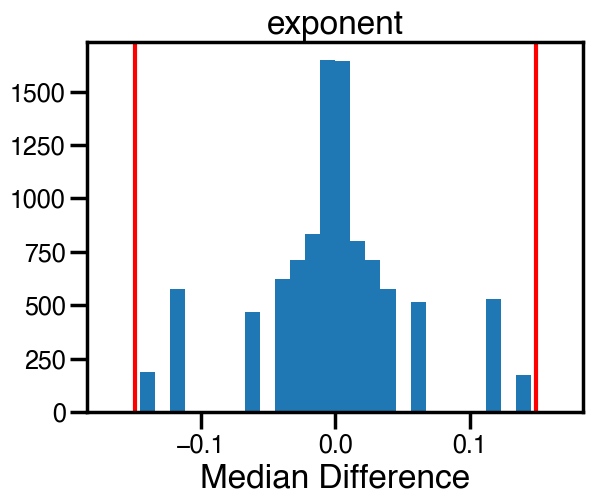

In [26]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

In [27]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.960138  0.466167    True
          W      pval  normal
0  0.951219  0.310117    True


**Distribution of means pre vs. post**

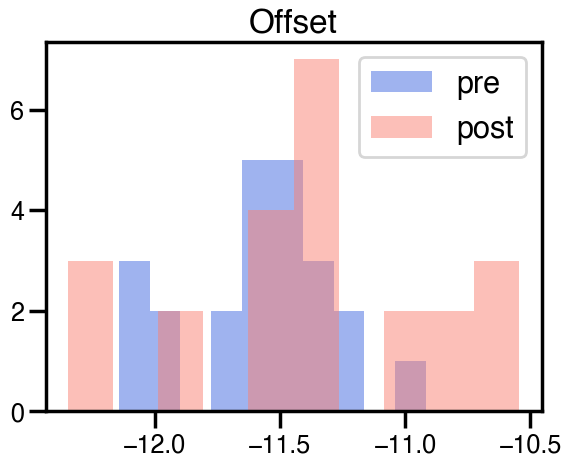

In [28]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

In [29]:
print(wilcoxon(means_pre, means_post))

          W-val alternative    p-val       RBC      CLES
Wilcoxon   68.0   two-sided  0.03267 -0.507246  0.349716


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.1451 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.388772   22   two-sided  0.025914  [-0.36, -0.03]  0.470521  2.235   

           power  
T-test  0.578282  


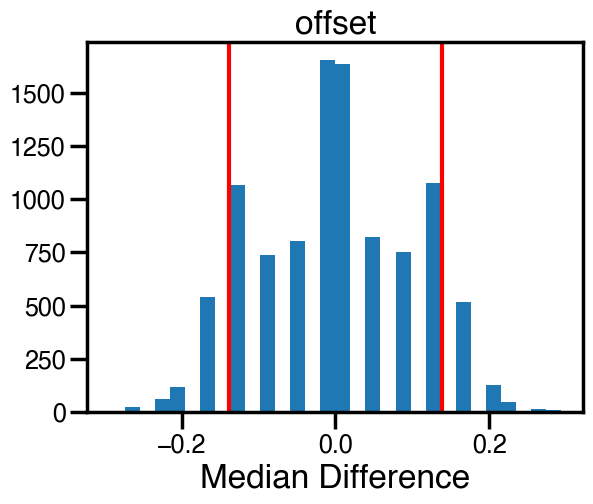

In [30]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [31]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.869281  0.063993    True
          W     pval  normal
0  0.942986  0.42141    True


In [32]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.16 std: 0.14
post: 0.37 std: 0.22


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

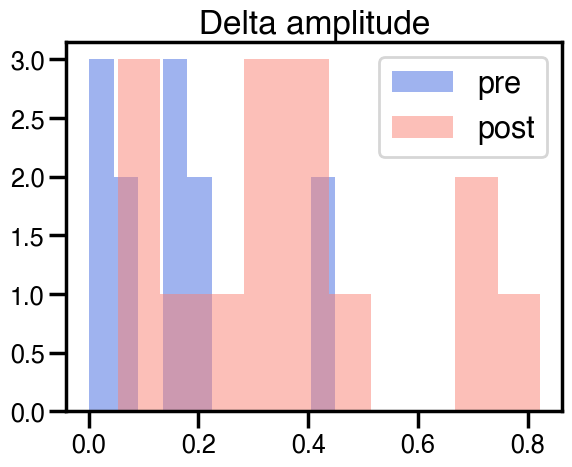

In [33]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

In [34]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC  CLES
Wilcoxon    1.0   two-sided  0.003906 -0.963636  0.19


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -3.258944    9   two-sided  0.009855  [-0.36, -0.07]  1.182009  6.272   

           power  
T-test  0.912694  


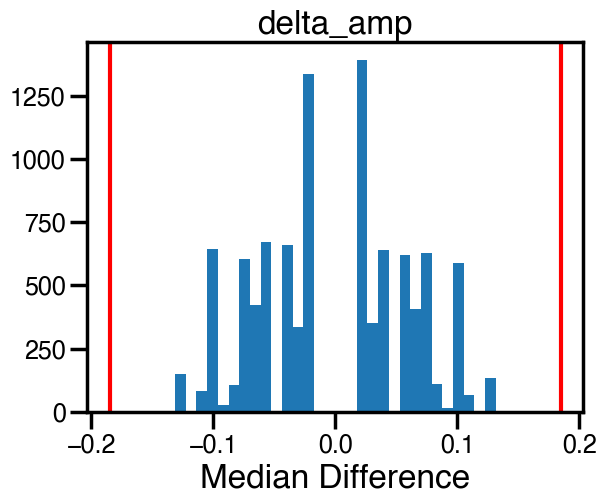

In [35]:
perm_test(exp_df_mean, feature='delta_amp')

### Delta Band Power: Pre/Post

**Normality**

In [36]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.968721  0.658414    True
          W      pval  normal
0  0.977717  0.863844    True


In [37]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.89 std: 0.27
post: -11.69 std: 0.5


**Distribution of means pre vs. post**

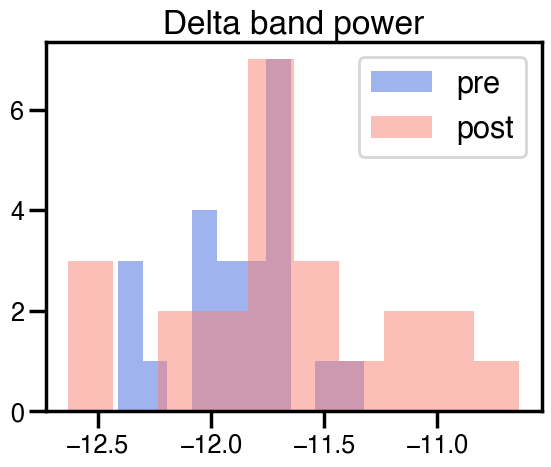

In [38]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [39]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   71.0   two-sided  0.041525 -0.485507  0.376181


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.5082 

               T  dof alternative     p-val           CI95%   cohen-d  BF10  \
T-test -2.412628   22   two-sided  0.024618  [-0.36, -0.03]  0.476373  2.33   

           power  
T-test  0.588735  


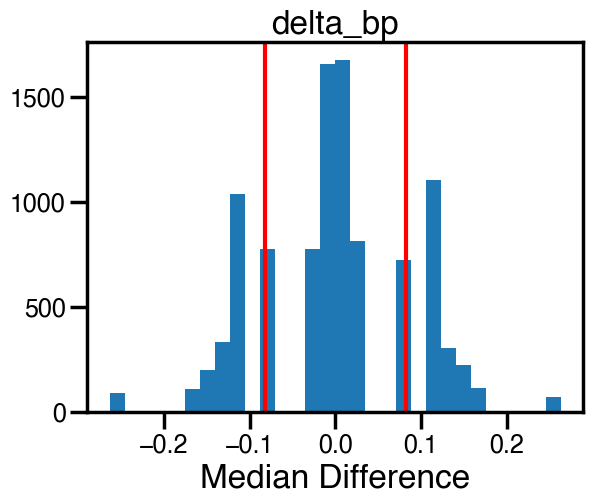

In [40]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [41]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.931574  0.397095    True
          W      pval  normal
0  0.848474  0.016524   False


**Distribution of means pre vs. post**

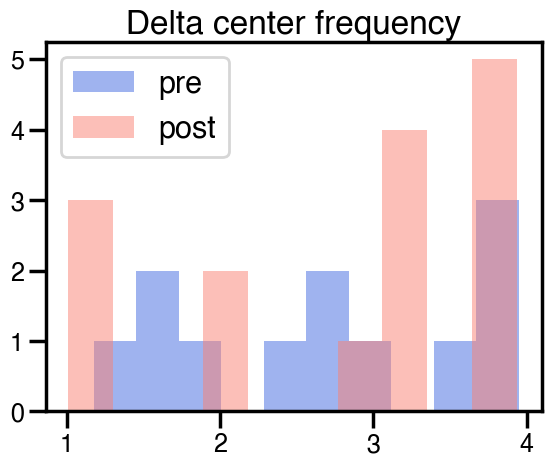

In [42]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [43]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val       RBC  CLES
Wilcoxon   18.0   two-sided  0.375  0.345455  0.58


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.2137 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.891306    9   two-sided  0.395968  [-0.51, 1.18]  0.315059  0.429   

           power  
T-test  0.145225  


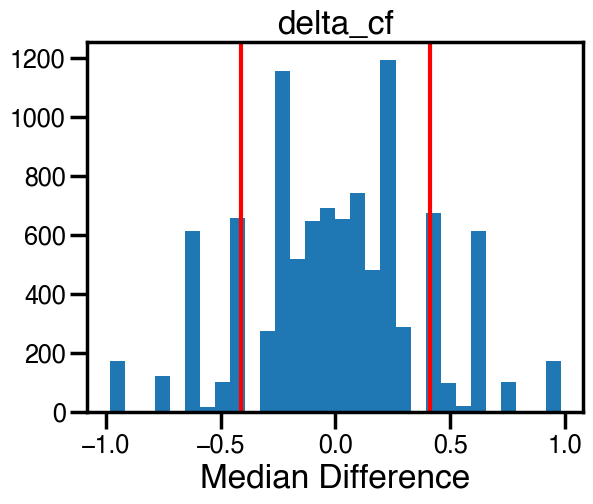

In [44]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [45]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.883544  0.020501   False
          W      pval  normal
0  0.922921  0.112792    True


In [46]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.36 std: 0.18
post: 0.61 std: 0.26


**Distribution of means pre vs. post**

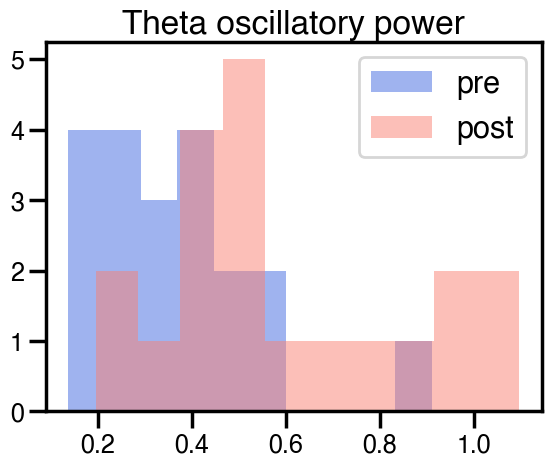

In [47]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [48]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    3.0   two-sided  0.000038 -0.964912  0.188272


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0434 

              T  dof alternative     p-val           CI95%   cohen-d     BF10  \
T-test -5.57174   17   two-sided  0.000034  [-0.34, -0.16]  1.121711  741.972   

           power  
T-test  0.994069  


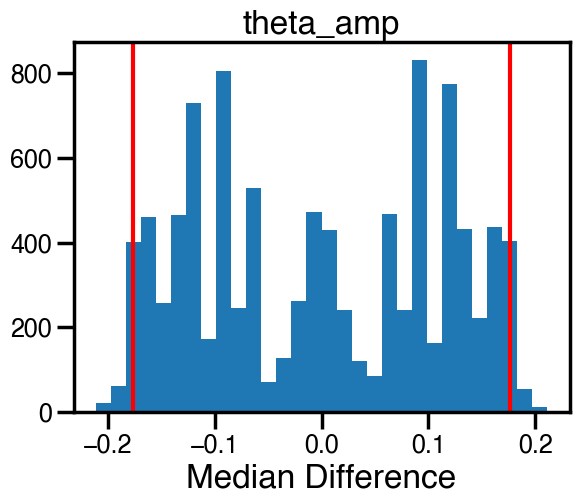

In [49]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Band Power: Pre/Post

**Normality**

In [50]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.966058  0.595612    True
          W      pval  normal
0  0.979246  0.892936    True


In [51]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.08 std: 0.38
post: -11.81 std: 0.6


**Distribution of means pre vs. post**

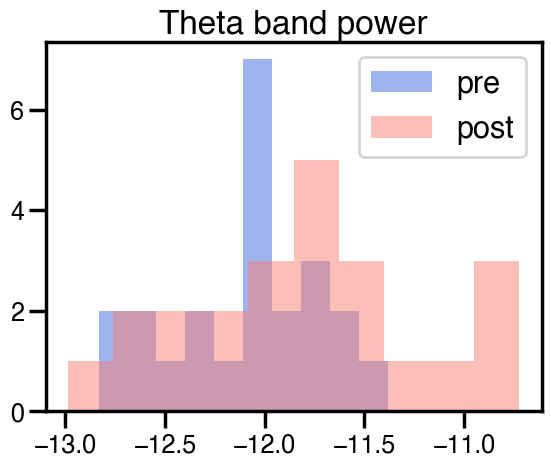

In [52]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta band power')
plt.show()

**Wilcoxon Test**

In [53]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   49.0   two-sided  0.005414 -0.644928  0.353497


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0781 

               T  dof alternative     p-val          CI95%   cohen-d    BF10  \
T-test -3.325482   22   two-sided  0.003071  [-0.44, -0.1]  0.534238  13.383   

           power  
T-test  0.687627  


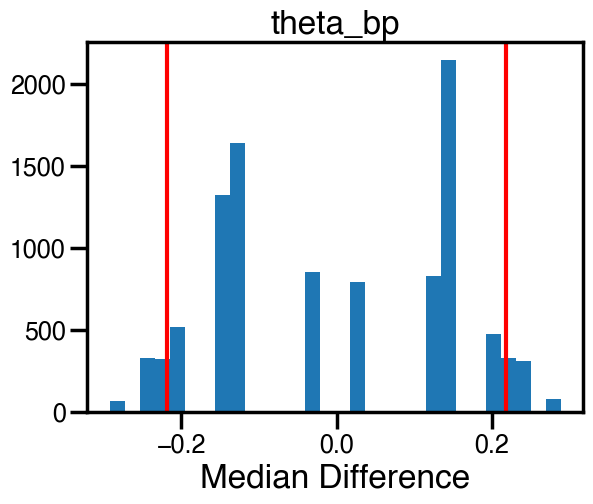

In [54]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [55]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.964745  0.64229    True
          W      pval  normal
0  0.965056  0.648938    True


**Distribution of means pre vs. post**

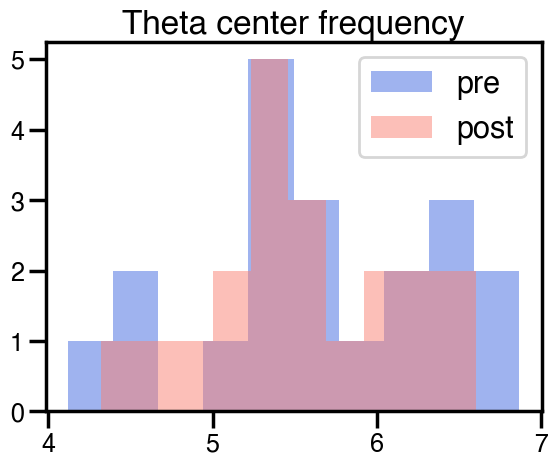

In [56]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [57]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   82.0   two-sided  0.898575  0.040936  0.552469


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.19829999999999998 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.619664   17   two-sided  0.543696  [-0.21, 0.39]  0.127068  0.288   

           power  
T-test  0.080204  


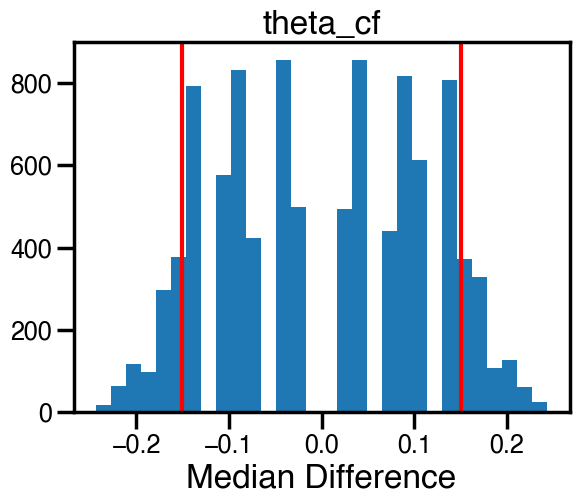

In [58]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [59]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.959286  0.449097    True
          W      pval  normal
0  0.982919  0.949327    True


In [60]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.16 std: 0.46
post: 1.1 std: 0.38


**Distribution of means pre vs. post**

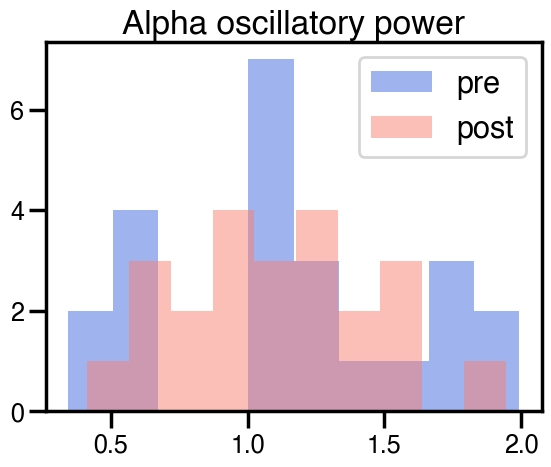

In [61]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [62]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  104.0   two-sided  0.314554  0.246377  0.536862


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.5052000000000001 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.793863   22   two-sided  0.435755  [-0.09, 0.19]  0.125638  0.291   

           power  
T-test  0.088879  


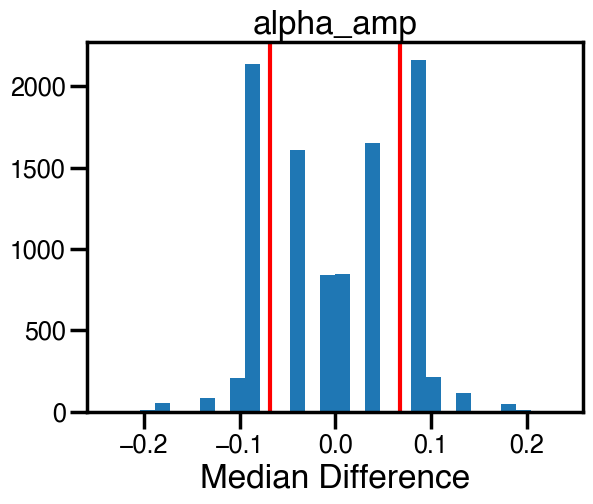

In [63]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Band Power: Pre/Post

**Normality**

In [64]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.971404  0.722567    True
          W      pval  normal
0  0.963898  0.546376    True


In [65]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.64 std: 0.46
post: -11.61 std: 0.49


**Distribution of means pre vs. post**

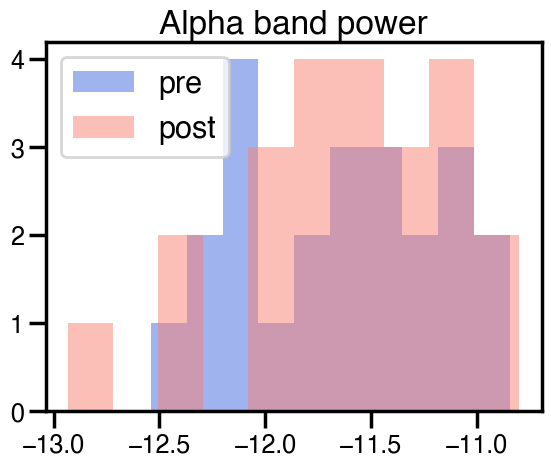

In [66]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha band power')
plt.show()

**Wilcoxon Test**

In [67]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  106.0   two-sided  0.344685 -0.231884  0.468809


**Permutation Test + T-Test**

The probability from the sampling statistics is =  0.1451 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.822397   22   two-sided  0.419675  [-0.12, 0.05]  0.072516  0.297   

           power  
T-test  0.062786  


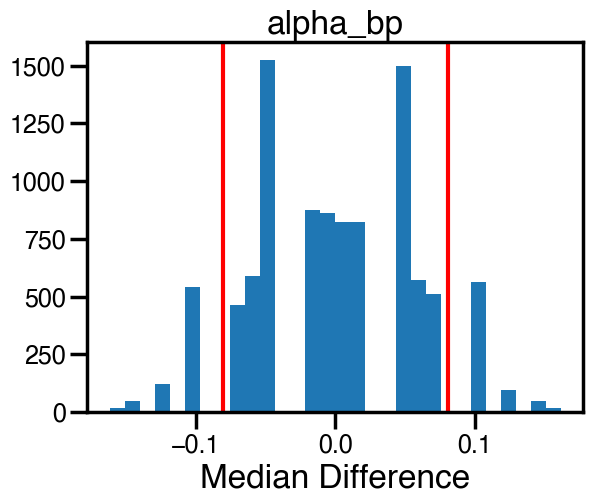

In [68]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [69]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.959729  0.457922    True
          W      pval  normal
0  0.956737  0.400754    True


**Distribution of means pre vs. post**

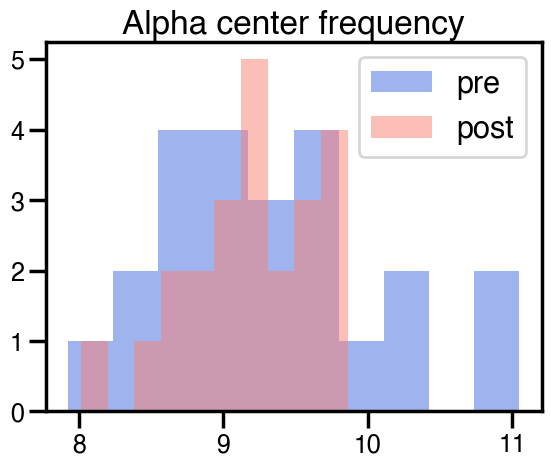

In [70]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [71]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  104.0   two-sided  0.314554  0.246377  0.519849


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.3532 

               T  dof alternative     p-val          CI95%   cohen-d BF10  \
T-test  1.372584   22   two-sided  0.183714  [-0.08, 0.38]  0.232677  0.5   

           power  
T-test  0.187339  


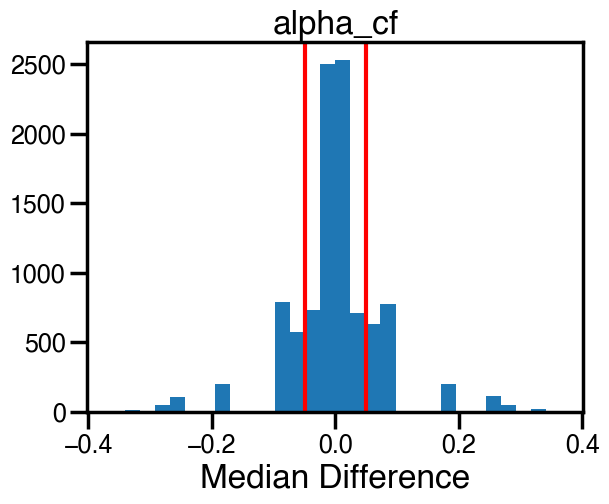

In [72]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta oscillation per participant, per pre/post

### Delta Percentage

In [73]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38454/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [74]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [75]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

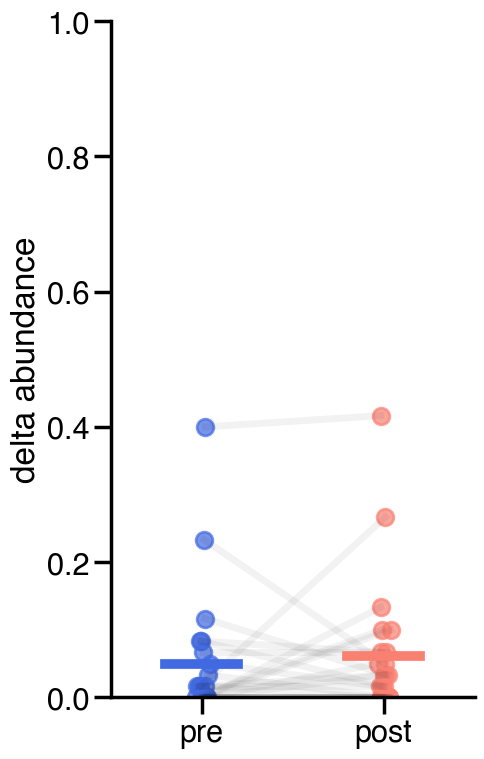

In [76]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylim(0, 1) # same y axis as ECT
plt.ylabel('delta abundance')
sns.despine()
plt.show()

**Normality**

In [77]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

         W          pval  normal
0  0.58734  6.572949e-07   False
          W      pval  normal
0  0.643416  0.000003   False


In [78]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.05 std: 0.09
post: 0.06 std: 0.1


**Wilcoxon Test**

In [79]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   50.5   two-sided  0.608946 -0.158333  0.426276


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0026 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.675356   22   two-sided  0.506486  [-0.05, 0.02]  0.120021  0.269   

           power  
T-test  0.085425  


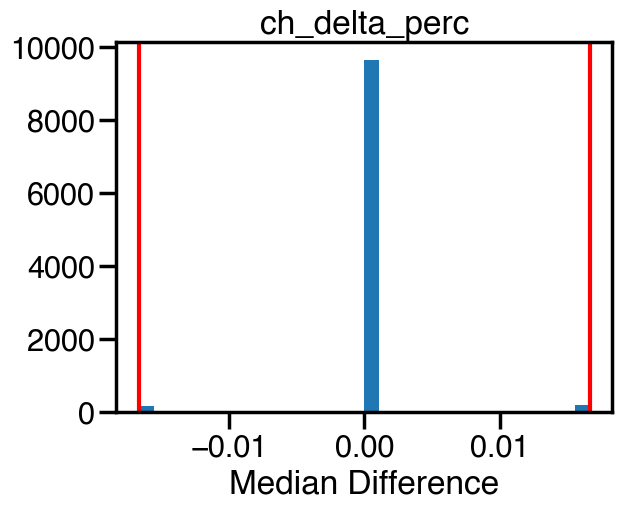

In [80]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [81]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38454/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [82]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [83]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

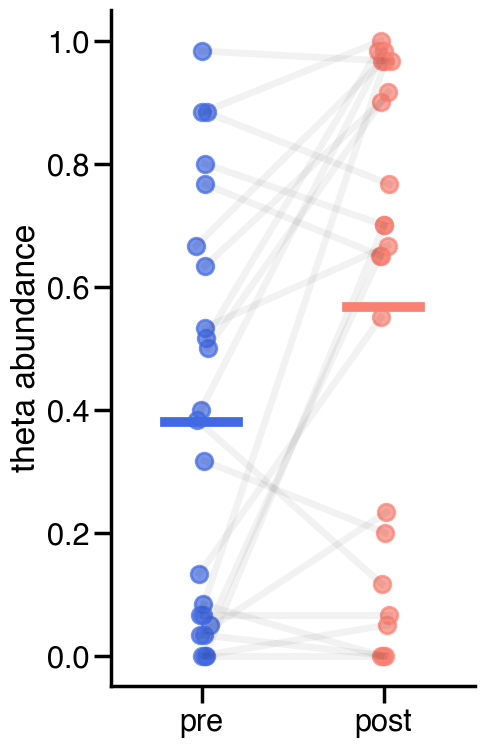

In [84]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.show()

In [85]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [86]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.38 std: 0.33
post: 0.57 std: 0.38


**Wilcoxon Test**

In [87]:
print(wilcoxon(perc_theta_pre, perc_theta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   46.0   two-sided  0.016456 -0.601732  0.345936


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d  BF10  \
T-test -2.883823   22   two-sided  0.008619  [-0.32, -0.05]  0.514567  5.56   

           power  
T-test  0.655094  


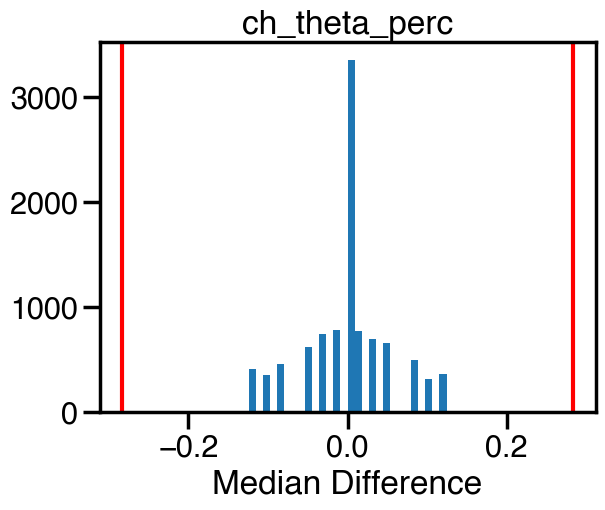

In [88]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [89]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38454/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [90]:
# With this new df, we want to group by the patient/pre_post to show how many channels have an alpha oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [91]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

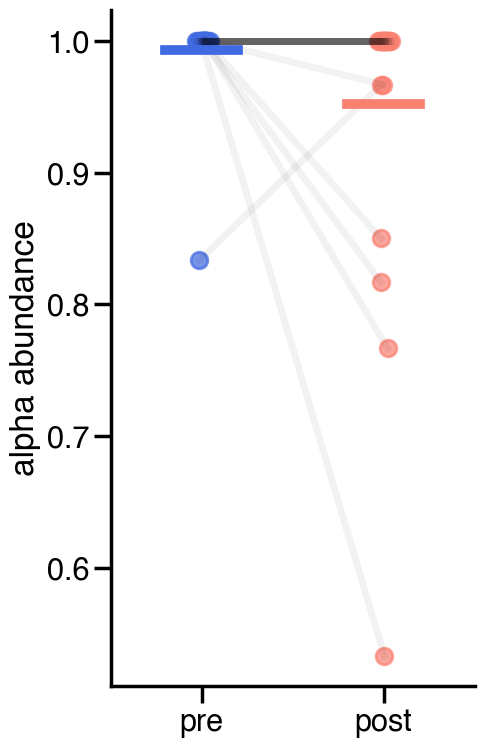

In [92]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
sns.despine()
plt.show()

In [93]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [94]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 0.99 std: 0.03
post: 0.95 std: 0.11


**Wilcoxon Test**

In [95]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    2.0   two-sided  0.093492  0.809524  0.608696


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.641197   22   two-sided  0.114977  [-0.01, 0.09]  0.487786  0.699   

          power  
T-test  0.60893  


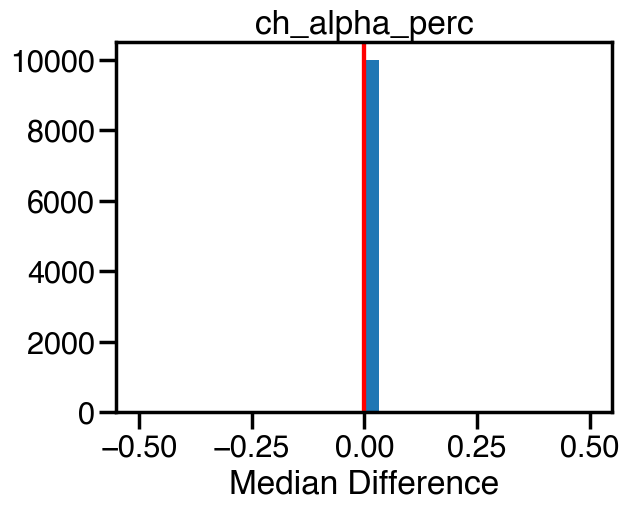

In [96]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [97]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [98]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [99]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,9,post,1.128304,-11.424854,NaN,-11.756255,0.532759,-11.790756,5.611765,NaN,1.058285,-11.688802,2.464601,9.304229,55,0.916667,0,0.000000,60,1.000000
1,9,pre,1.473953,-10.917829,0.146205,-11.321277,0.406346,-11.572985,5.350125,2.005953,1.024964,-11.451574,3.584126,9.112030,30,0.500000,2,0.033333,60,1.000000
2,10,post,0.860782,-12.345734,0.686029,-12.632333,NaN,-12.986079,NaN,1.007784,0.411048,-12.931506,2.054040,9.798821,0,0.000000,4,0.066667,49,0.816667
3,10,pre,0.919661,-12.052613,0.040532,-12.369279,0.177274,-12.697551,6.479903,2.453152,0.539035,-12.540055,2.403896,9.550233,5,0.083333,4,0.066667,60,1.000000
4,18,post,1.094980,-11.289992,0.139738,-11.638065,0.489579,-11.971259,6.424628,1.017573,1.112956,-11.496834,1.591604,8.759194,7,0.116667,1,0.016667,60,1.000000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the band power differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [100]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38454/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,0.345650,0.507025,NaN,0.434978,-0.126412,0.217771,-0.261639,NaN,-0.033322,0.237228,-0.192200,-0.416667,0.033333,0.000000,9
3,0.058879,0.293121,-0.645497,0.263054,NaN,0.288528,NaN,1.445367,0.127987,0.391452,-0.248588,0.083333,0.000000,0.183333,10
5,0.115917,0.042335,-0.139468,-0.026524,-0.142296,0.134673,-1.167935,1.732426,0.012112,-0.016471,-0.024780,0.266667,0.000000,0.000000,18
7,-0.184502,-0.369752,NaN,-0.379509,-0.236117,-0.450002,0.208337,NaN,0.285625,-0.103030,0.006089,0.000000,0.000000,0.000000,22
9,0.006095,0.460970,NaN,0.492491,0.107728,0.320137,1.483624,NaN,-0.787376,-0.288198,-0.800865,0.116667,-0.033333,0.000000,25
11,-0.494473,-0.526216,NaN,-0.522628,-0.440249,-0.488498,-0.152538,NaN,0.204019,0.044466,0.058184,-0.266667,-0.133333,0.000000,33
13,-0.138135,-0.224031,-0.082597,-0.257054,-0.370930,-0.371153,-0.376757,0.095263,0.103503,0.007112,-0.089036,-0.583333,0.066667,0.466667,35
15,-0.336703,-0.497272,NaN,-0.305903,NaN,-0.240698,NaN,NaN,-0.080094,-0.191702,0.365053,0.000000,0.000000,0.033333,40
17,-0.036711,-0.005157,NaN,0.004755,-0.057284,-0.025370,-0.021891,NaN,0.087367,0.072388,-0.023627,-0.116667,0.000000,0.000000,46
19,0.144388,0.266258,-0.043819,0.160960,NaN,0.344395,NaN,1.928677,-0.289977,0.098429,-0.626846,0.033333,0.183333,0.000000,47


In [101]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     31.88
Date:                Thu, 18 May 2023   Prob (F-statistic):           6.02e-07
Time:                        14:01:49   Log-Likelihood:                 6.2004
No. Observations:                  23   AIC:                            -6.401
Df Residuals:                      20   BIC:                            -2.994
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0383      0.051      0.750

In [102]:
model = ols('theta_bp ~ exponent + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     28.20
Date:                Thu, 18 May 2023   Prob (F-statistic):           1.51e-06
Time:                        14:01:49   Log-Likelihood:                 4.6967
No. Observations:                  23   AIC:                            -3.393
Df Residuals:                      20   BIC:                           0.01312
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0167      0.057     -0.294

In [103]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     7.622
Date:                Thu, 18 May 2023   Prob (F-statistic):            0.00153
Time:                        14:01:49   Log-Likelihood:                 13.298
No. Observations:                  23   AIC:                            -18.60
Df Residuals:                      19   BIC:                            -14.05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0207      0.040      0.519

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='theta_amp', ylabel='theta_bp'>

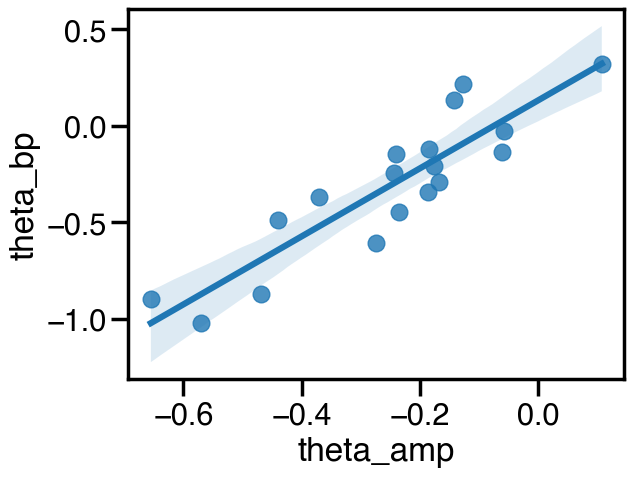

In [104]:
sns.regplot(diff_df_mean_wperc['theta_amp'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_theta_perc', ylabel='theta_bp'>

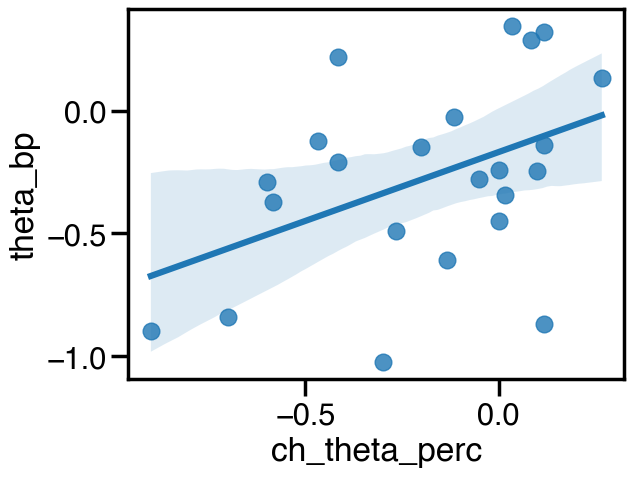

In [105]:
sns.regplot(diff_df_mean_wperc['ch_theta_perc'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='offset', ylabel='theta_bp'>

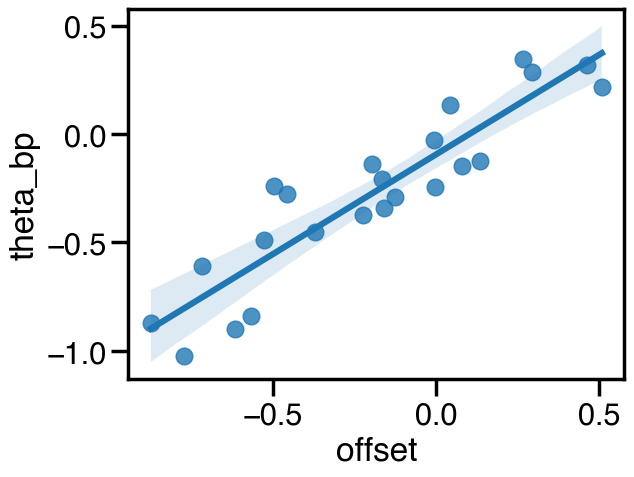

In [106]:
sns.regplot(diff_df_mean_wperc['offset'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='theta_bp'>

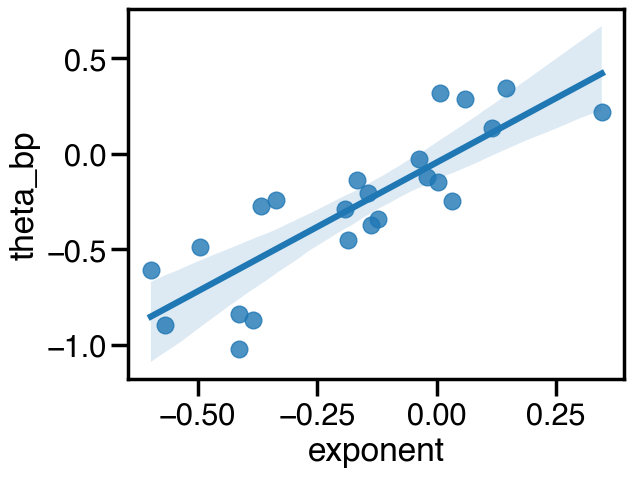

In [107]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='delta_bp'>

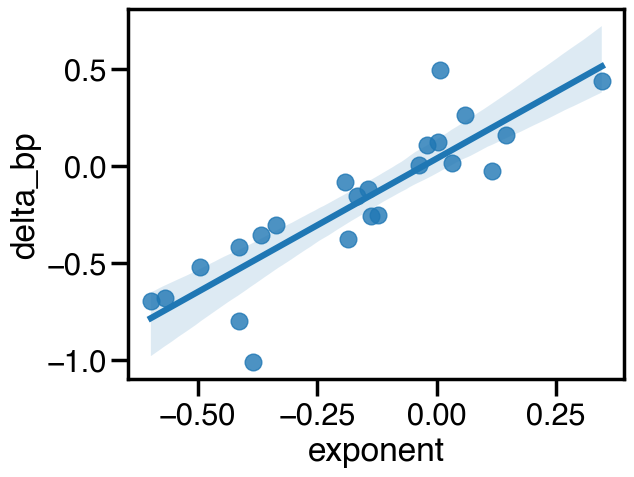

In [108]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['delta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='delta_amp', ylabel='delta_bp'>

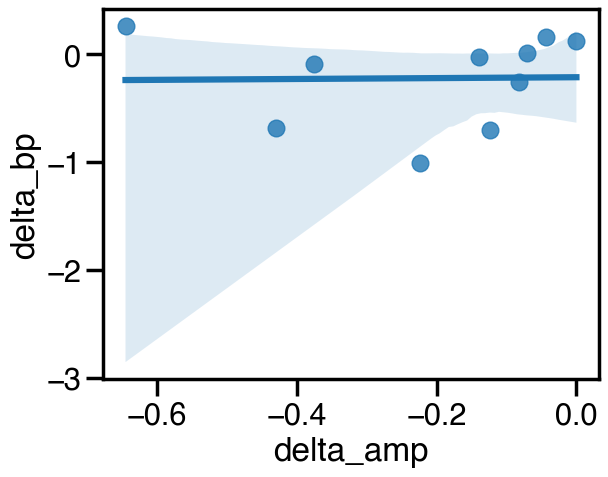

In [109]:
sns.regplot(diff_df_mean_wperc['delta_amp'], diff_df_mean_wperc['delta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_delta_perc', ylabel='delta_bp'>

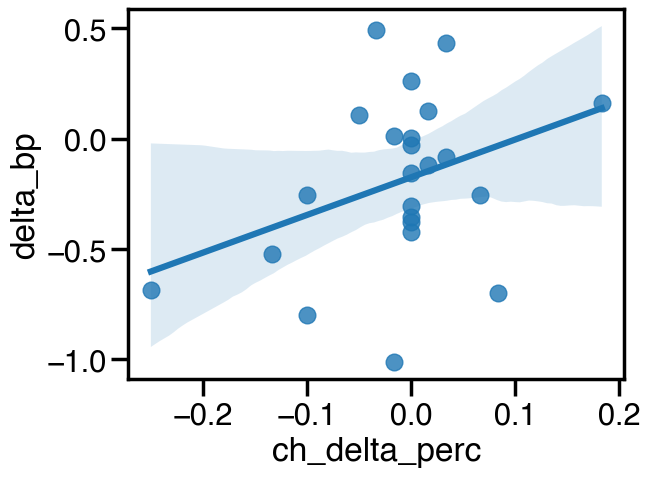

In [110]:
sns.regplot(diff_df_mean_wperc['ch_delta_perc'], diff_df_mean_wperc['delta_bp'])